In [28]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [30]:
data = yf.download("^NSEI", start="2018-01-01", interval="1wk")
data.columns = data.columns.get_level_values(0)
data["returns"]=data["Close"].pct_change()
data.dropna(inplace=True)
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,returns
Date,,,,,,
2018-01-08,10681.250000,10690.400391,10588.549805,10591.700195,879400,0.011592
2018-01-15,10894.700195,10906.849609,10666.750000,10718.500000,1159200,0.019984
2018-01-22,11069.650391,11110.099609,10881.400391,10883.200195,1129900,0.016058
2018-01-29,10760.599609,11171.549805,10736.099609,11079.349609,1304500,-0.027919
2018-02-05,10454.950195,10702.750000,10276.299805,10604.299805,1180800,-0.028404


In [32]:
data["returns"] = data["Close"].pct_change()
data["ret_5"] = data["Close"].pct_change(5)
data["vol_5"] = data["returns"].rolling(5).std()
data.dropna(inplace=True)
data.head()

Price,Close,High,Low,Open,Volume,returns,ret_5,vol_5
Date,,,,,,,,
2018-03-19,9998.049805,10227.299805,9951.900391,10215.349609,1134200,-0.019333,-0.043459,0.011292
2018-03-26,10113.700195,10207.900391,9958.549805,9989.150391,832700,0.011567,-0.035969,0.013747
2018-04-02,10331.599609,10350.450195,10111.299805,10151.650391,1098800,0.021545,-0.012120,0.019007
2018-04-09,10480.599609,10519.900391,10328.500000,10333.700195,1175400,0.014422,0.024812,0.016304
2018-04-16,10564.049805,10594.200195,10396.349609,10398.299805,1113700,0.007962,0.036184,0.015665


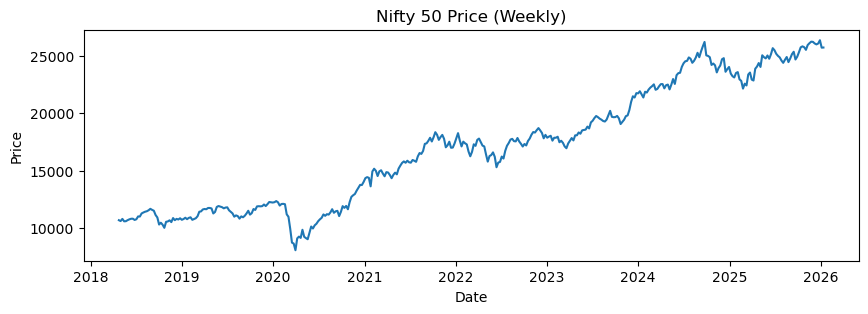

In [64]:
plt.figure(figsize =(10,3))
plt.plot(data.index, data["Close"])
plt.title("Nifty 50 Price (Weekly)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

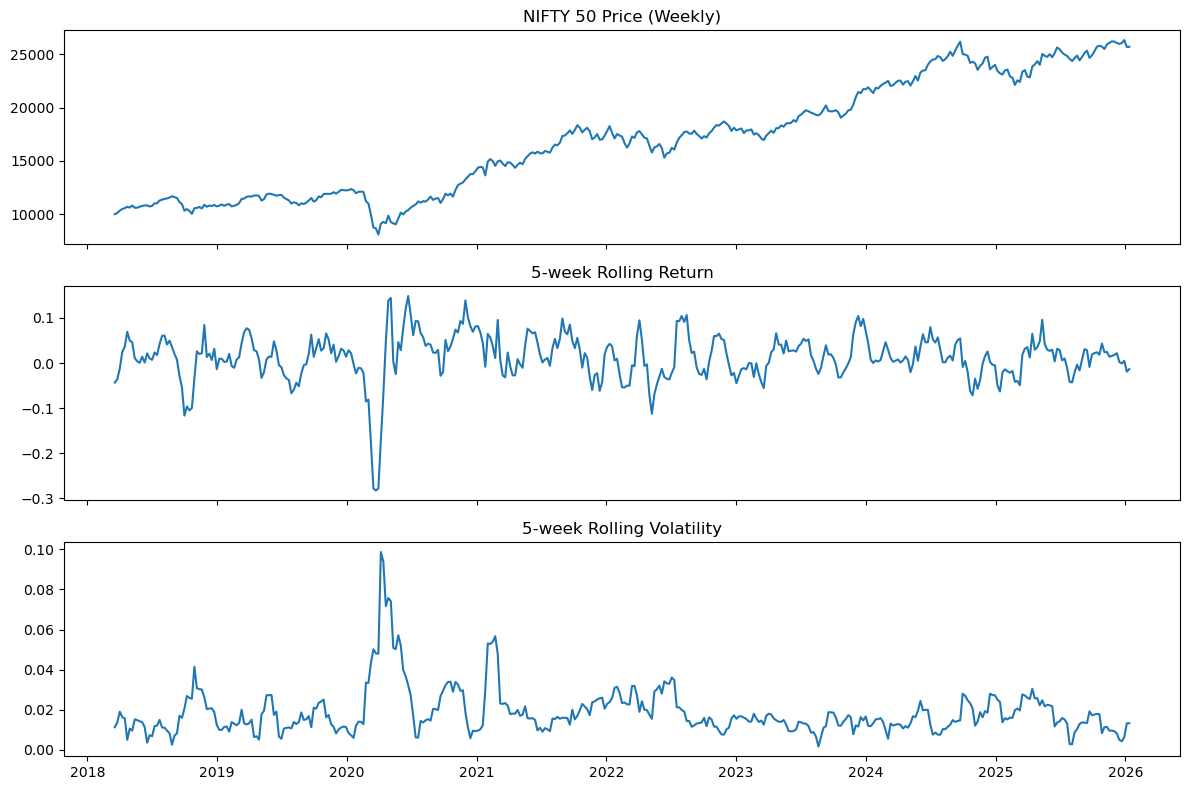

In [36]:
fig, ax = plt.subplots(3, 1, figsize=(12,8), sharex=True)

ax[0].plot(data.index, data["Close"])
ax[0].set_title("NIFTY 50 Price (Weekly)")

ax[1].plot(data.index, data["ret_5"])
ax[1].set_title("5-week Rolling Return")
ax[2].plot(data.index, data["vol_5"])
ax[2].set_title("5-week Rolling Volatility")
plt.tight_layout()
plt.show()

In [37]:
data["returns"] = data["Close"].pct_change()
data["ret_5"] = data["Close"].pct_change(5)
data["vol_5"] = data["returns"].rolling(5).std()

data.dropna(inplace=True)
data.head()


Price,Close,High,Low,Open,Volume,returns,ret_5,vol_5
Date,,,,,,,,
2018-04-23,10692.299805,10719.799805,10514.950195,10592.799805,937700,0.012140,0.069439,0.005045
2018-04-30,10618.250000,10784.650391,10601.599609,10705.750000,775200,-0.006926,0.049888,0.010582
2018-05-07,10806.500000,10812.049805,10635.650391,10653.150391,1048800,0.017729,0.045966,0.009619
2018-05-14,10596.400391,10929.200195,10589.099609,10815.150391,1093900,-0.019442,0.011049,0.015205
2018-05-21,10605.150391,10628.049805,10417.799805,10616.700195,1091000,0.000826,0.003891,0.014871


In [38]:
def manual_regime(row):
    if row["ret_5"] > 0.02 and row["vol_5"] < 0.02:
        return "Bull"
    elif row["ret_5"] < -0.02:
        return "Bear"
    else:
        return "Sideways"

In [39]:
data["regime_manual"] = data.apply(manual_regime, axis=1)
data["regime_manual"].value_counts()

regime_manual
Sideways    191
Bull        129
Bear         84
Name: count, dtype: int64

In [40]:
features = data[["ret_5", "vol_5"]]

In [41]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [42]:
kmeans = KMeans(n_clusters=3, random_state=42)
data["regime_ml"] = kmeans.fit_predict(features_scaled)

C:\Users\atulk\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [43]:
data.groupby("regime_ml")[["ret_5", "vol_5"]].mean()

Price,ret_5,vol_5
regime_ml,,
0,-0.016371,0.029173
1,0.027045,0.014305
2,-0.209446,0.063648


In [40]:
features = data[["ret_5", "vol_5"]]

In [44]:
regime_map = {
    0: "Sideways",
    1: "Bull",
    2: "Bear"
}

In [45]:
data["regime_ml_label"] = data["regime_ml"].map(regime_map)
data["regime_ml_label"].value_counts()

regime_ml_label
Bull        299
Sideways     99
Bear          6
Name: count, dtype: int64

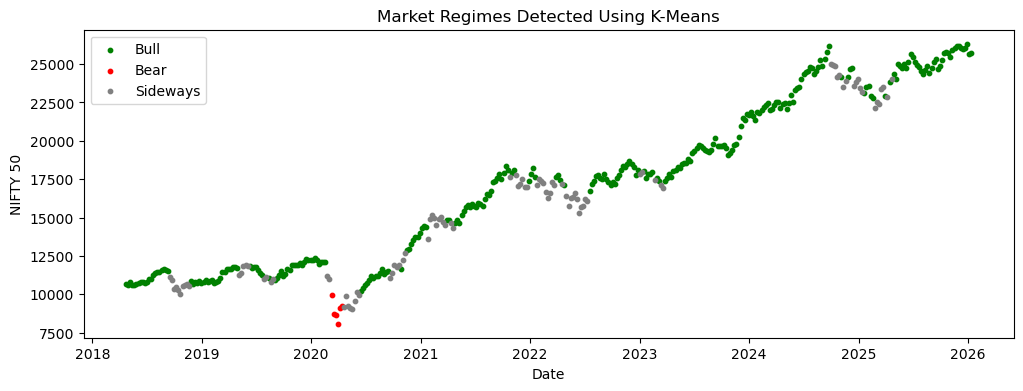

In [46]:
plt.figure(figsize=(12,4))
for regime, color in zip(
    ["Bull", "Bear", "Sideways"],
    ["green", "red", "gray"]
):
    subset = data[data["regime_ml_label"] == regime]
    plt.scatter(subset.index, subset["Close"], s=10, label=regime, color=color)
plt.legend()
plt.title("Market Regimes Detected Using K-Means")
plt.xlabel("Date")
plt.ylabel("NIFTY 50")
plt.show()

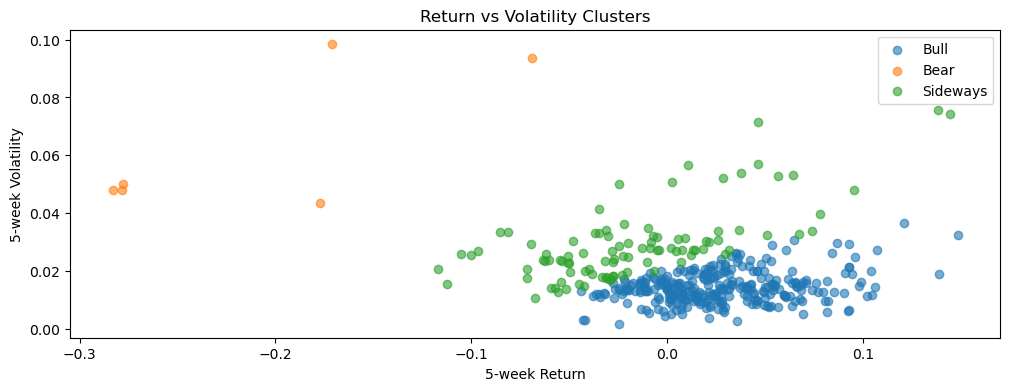

In [47]:
plt.figure(figsize=(12,4))
for label, color in zip(
    ["Bull", "Bear", "Sideways"],
    ["green", "red", "gray"]
):
    subset = data[data["regime_ml_label"] == label]
    plt.scatter(
        subset["ret_5"],
        subset["vol_5"],
        alpha=0.6,
        label=label
    )
plt.xlabel("5-week Return")
plt.ylabel("5-week Volatility")
plt.legend()
plt.title("Return vs Volatility Clusters")
plt.show()

In [48]:
data["next_regime"] = data["regime_ml_label"].shift(-1)
transition_matrix = pd.crosstab(
    data["regime_ml_label"],
    data["next_regime"],
    normalize="index"
)
transition_matrix

next_regime,Bear,Bull,Sideways
regime_ml_label,,,
Bear,0.833333,0.000000,0.166667
Bull,0.000000,0.922819,0.077181
Sideways,0.010101,0.232323,0.757576


In [49]:
data["regime_change"] = (
    data["regime_ml_label"] != data["regime_ml_label"].shift()
)
data["regime_id"] = data["regime_change"].cumsum()
regime_duration = (
    data.groupby(["regime_id", "regime_ml_label"])
    .size()
    .reset_index(name="weeks")
)
regime_duration.head()

,regime_id,regime_ml_label,weeks
0,1,Bull,21
1,2,Sideways,10
2,3,Bull,23
3,4,Sideways,5
4,5,Bull,7


In [50]:
regime_duration.groupby("regime_ml_label")["weeks"].mean()

regime_ml_label
Bear         6.000000
Bull        12.458333
Sideways     4.125000
Name: weeks, dtype: float64

In [51]:
data["bh_return"] = data["returns"]
bh_perf = data.groupby("regime_ml_label")["bh_return"].mean()
bh_perf

regime_ml_label
Bear       -0.024627
Bull        0.004951
Sideways   -0.003444
Name: bh_return, dtype: float64

In [52]:
data["momentum_signal"] = (data["ret_5"] > 0).astype(int)
data["momentum_return"] = data["momentum_signal"] * data["returns"]
momentum_perf = data.groupby("regime_ml_label")["momentum_return"].mean()
momentum_perf

regime_ml_label
Bear        0.000000
Bull        0.005653
Sideways    0.003727
Name: momentum_return, dtype: float64

In [53]:
comparison = pd.DataFrame({
    "Buy_and_Hold": bh_perf,
    "Momentum": momentum_perf
})
comparison

,Buy_and_Hold,Momentum
regime_ml_label,,
Bear,-0.024627,0.000000
Bull,0.004951,0.005653
Sideways,-0.003444,0.003727


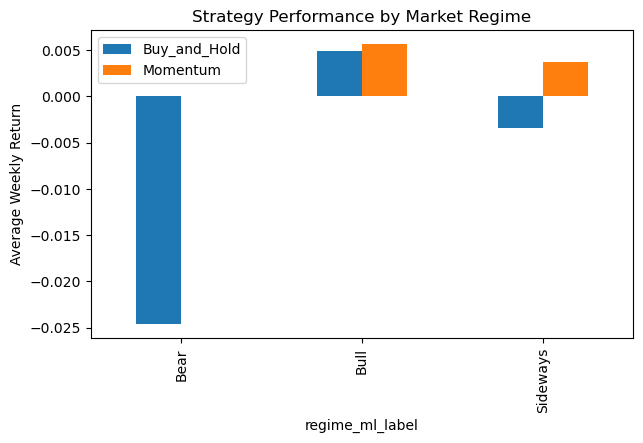

In [59]:
comparison.plot(kind="bar", figsize=(7,4))
plt.title("Strategy Performance by Market Regime")
plt.ylabel("Average Weekly Return")
plt.show()

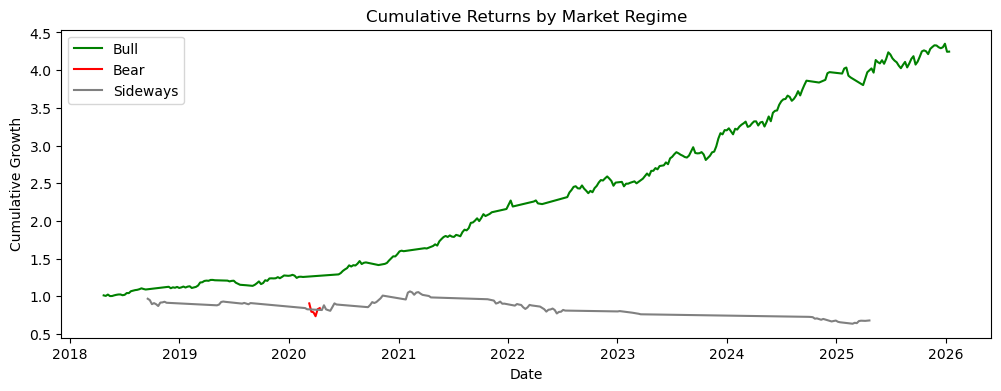

In [60]:
plt.figure(figsize=(12,4))
for regime, color in zip(
    ["Bull", "Bear", "Sideways"],
    ["green", "red", "gray"]
):
    subset = data[data["regime_ml_label"] == regime]
    cum_return = (1 + subset["returns"]).cumprod()
    plt.plot(subset.index, cum_return, label=regime, color=color)
plt.legend()
plt.title("Cumulative Returns by Market Regime")
plt.ylabel("Cumulative Growth")
plt.xlabel("Date")
plt.show()

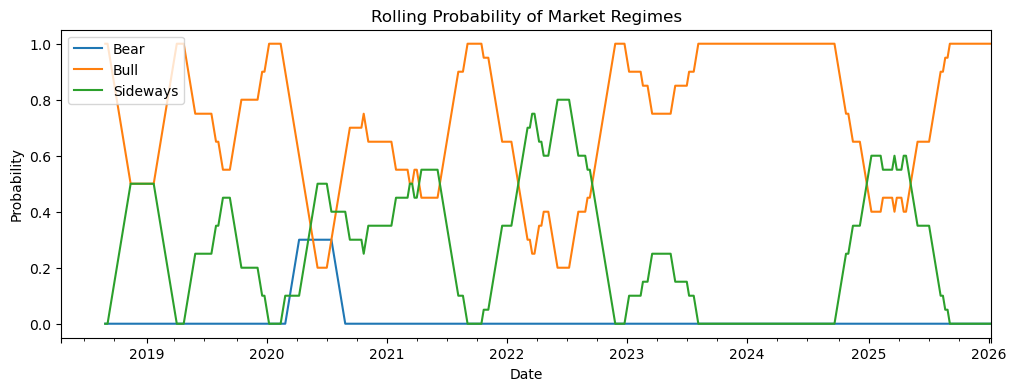

In [62]:
window = 20  # rolling weeks
regime_probs = (
    pd.get_dummies(data["regime_ml_label"])
    .rolling(window)
    .mean()
)
regime_probs.plot(figsize=(12,4))
plt.title("Rolling Probability of Market Regimes")
plt.ylabel("Probability")
plt.xlabel("Date")
plt.show()

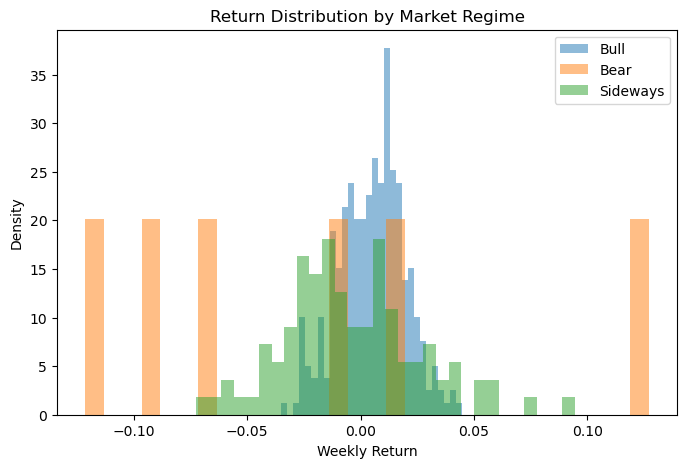

In [63]:
plt.figure(figsize=(8,5))
for regime, color in zip(
    ["Bull", "Bear", "Sideways"],
    ["green", "red", "gray"]
):
    subset = data[data["regime_ml_label"] == regime]
    plt.hist(
        subset["returns"],
        bins=30,
        alpha=0.5,
        label=regime,
        density=True
    )
plt.legend()
plt.title("Return Distribution by Market Regime")
plt.xlabel("Weekly Return")
plt.ylabel("Density")
plt.show()